In [205]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('agg')

pd.set_option('max_columns', 999)
pd.set_option('max_rows', 250)

import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

seed = 60611

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

import time

In [130]:
class ArvatoData:
    
    def __init__(self, attributes_data_location=None, azdias_data_location=None, customer_data_location=None):
        self.attributes_data_location = attributes_data_location or 'data/DIAS Attributes - Values 2017.xlsx'
        self.azdias_data_location = azdias_data_location or 'data/arvato_data/Udacity_AZDIAS_052018.csv'
        self.customer_data_location = customer_data_location or 'data/arvato_data/Udacity_CUSTOMERS_052018.csv'
        
        self.data_prep_utils = {
            'one_hot_enc_no_del': ['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ'],
            'one_hot_enc_del': ['ANREDE_KZ']
        }
        
        self.raw_data = dict()
        self.prepped_data = dict()
        
    def only_named_columns(self, col):
        """
        Removes columns from DataFrame while loaded that are unnamed
        """
        return 'Unnamed' not in col
            
    def load_data(self, ignore_clean_cache=False):

        # Attributes and Information
        print('loading attribute data from {}'.format(self.attributes_data_location))
        self.raw_data['attributes'] = pd.read_excel(self.attributes_data_location, header=1, usecols=self.only_named_columns)
        self.raw_data['attributes'][['Attribute', 'Description']] = self.raw_data['attributes'][['Attribute', 'Description']].ffill()

#         information = pd.read_excel('data/DIAS Information Levels - Attributes 2017.xlsx', header=1, usecols=only_named_columns)

        print('loading azdias data from {}'.format(self.azdias_data_location))
        self.raw_data['azdias'] = pd.read_csv(self.azdias_data_location, sep=';', usecols=self.only_named_columns)
        print('loading customers data from {}'.format(self.customer_data_location))
        self.raw_data['customers'] = pd.read_csv(self.customer_data_location, sep=';', usecols=self.only_named_columns)
#         print('loading mailout test data')
#         self.mailout_test = pd.read_csv('data/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';', usecols=only_named_columns)
#         print('loading mailout training data')
#         self.mailout_train = pd.read_csv('data/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', usecols=only_named_columns)
        print('Raw Data Loaded!')
    
    # Begin section of helper functions for data prep
    def lookup_unknown_val(self, col, attributes):
        try:
            mask = (attributes['Attribute'] == col) & (attributes['Meaning'].str.startswith('unknown'))
            unknown_val = attributes.loc[mask, 'Value']
            split_string = unknown_val.astype(str).str.cat(sep=',')
            
            return [int(x) for x in split_string.split(',')]
        except ValueError:
            return []
    
    def replace_unknowns_with_nan(self, df, attributes):
        for col in df.columns:
            df.loc[:, col] = df[col].replace(self.lookup_unknown_val(col, attributes), np.nan)
        return df
    
    def missing_percentages(self, df):
        missing = pd.DataFrame(df.isna().sum() / df.shape[0]).reset_index()
        missing.columns = ['Attribute', 'Missing']
        return missing
    
    def remove_features_by_missingness(self, df, threshold=1):
        missing = self.missing_percentages(df)
        cols = missing.loc[missing['Missing'] > threshold, 'Attribute'].tolist()
        return cols
    
    def safe_drop_columns(self, df, cols):
        drop_cols = list(set(df.columns).intersection(set(cols)))
        return df.drop(drop_cols, axis=1)
    
    def clean_columns_18_19(self, df):
        columns = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']
        df[columns] = df.loc[:, columns].replace(['X', 'XX'], np.nan)
        df[columns] = df.loc[:, columns].astype(float)
        return df
    
    def one_hot_encode(self, df, col, drop_first=False):
        dummies = pd.get_dummies(df[col], drop_first=drop_first)
        df_list = [df.drop(col, axis=1), dummies]
        return pd.concat(df_list, axis=1)
        
    def return_scaled_columns_list(self, df):
        scaled, not_scaled = df.select_dtypes(exclude='uint8').columns.tolist(), df.select_dtypes(include='uint8').columns.tolist()
        return scaled, not_scaled

    def create_scaler(self, df):
        scaled_col_list, non_scaled_col_list = self.return_scaled_columns_list(df)
        scaler = StandardScaler()
        scaler.fit(df[scaled_col_list])
        return scaler
    
    def scale_dataframe(self, df, scaler):
        scaled_col_list, non_scaled_col_list = self.return_scaled_columns_list(df)
        scaled_df = scaler.transform(df[scaled_col_list])
        return pd.DataFrame(np.hstack([scaled_df, df[non_scaled_col_list]]), columns=df.columns)

    def create_imputer(self, df):
        imputer = SimpleImputer(strategy='median')
        imputer.fit(df)
        return imputer
    
    def impute_values(self, df, imputer):
        return pd.DataFrame(imputer.transform(df), columns=df.columns)
    
    def fit(self, reload_azdias=False):
        
        # lookup unknowns
        self.raw_data['azdias'] = self.replace_unknowns_with_nan(self.raw_data['azdias'], self.raw_data['attributes'])
        
        # fix errors when loading
        self.raw_data['azdias'] = self.clean_columns_18_19(self.raw_data['azdias'])
        
        # drop columns that we don't have an explanation for, but keep the one object column
        drop_cols = list(set(self.raw_data['azdias'].columns) - set(self.raw_data['attributes']['Attribute'].unique()))
        drop_cols.remove('D19_LETZTER_KAUF_BRANCHE')
        
        # find features that are missing too much data, drop them
        missingness_cols = self.remove_features_by_missingness(self.raw_data['azdias'], 0.2)
        missingness_cols.remove('D19_LETZTER_KAUF_BRANCHE')

        drop_cols.extend(missingness_cols)
        
        self.data_prep_utils['column_mask'] = list(set(self.raw_data['azdias'].columns) - set(drop_cols))
        self.raw_data['azdias'] = self.raw_data['azdias'][self.data_prep_utils['column_mask']]
        
        # one hot encode
        self.raw_data['azdias'] = self.one_hot_encode(self.raw_data['azdias'], self.data_prep_utils['one_hot_enc_del'], True)
        self.raw_data['azdias'] = self.one_hot_encode(self.raw_data['azdias'], self.data_prep_utils['one_hot_enc_no_del'], False)
        
        # scale
        scaler = self.create_scaler(self.raw_data['azdias'])
        self.data_prep_utils['scaler'] = scaler

        self.raw_data['azdias'] = self.scale_dataframe(self.raw_data['azdias'], self.data_prep_utils['scaler'])
        
        # impute
        imputer = self.create_imputer(self.raw_data['azdias'])
        self.data_prep_utils['imputer'] = imputer

        self.raw_data['azdias'] = self.impute_values(self.raw_data['azdias'], self.data_prep_utils['imputer'])
        
        if reload_azdias:
            print('loading azdias data from {}'.format(self.azdias_data_location))
            self.raw_data['azdias'] = pd.read_csv(self.azdias_data_location, sep=';', usecols=self.only_named_columns)
            print('Finished reloading azdias!')
        
    def transform(self, df):
        
        # lookup unknowns
        print('Replacing unknowns...')
        df = self.replace_unknowns_with_nan(df, self.raw_data['attributes'])
        
        # fix errors when loading
        print('Fixing columns 18 and 19...')
        df = self.clean_columns_18_19(df)
        
        # drop columns not in azdias prep
        print('Remove extraneous columns')
        df = df[self.data_prep_utils['column_mask']]
        
        # one hot encode
        print('One Hot Encode...')
        df = self.one_hot_encode(df, self.data_prep_utils['one_hot_enc_del'], True)
        df = self.one_hot_encode(df, self.data_prep_utils['one_hot_enc_no_del'], False)
        
        # scale
        print('Scaling...')
        df = self.scale_dataframe(df, self.data_prep_utils['scaler'])
        
        # impute
        print('Imputing...')
        df = self.impute_values(df, self.data_prep_utils['imputer'])
        
        return df
    

In [131]:
a = ArvatoData()

In [132]:
a.load_data()

loading attribute data from data/DIAS Attributes - Values 2017.xlsx
loading azdias data from data/arvato_data/Udacity_AZDIAS_052018.csv


/home/patrick/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


loading customers data from data/arvato_data/Udacity_CUSTOMERS_052018.csv
Raw Data Loaded!


In [133]:
a.raw_data['azdias'].shape[0]

891221

In [134]:
a.fit()

In [135]:
a.raw_data['azdias'].shape[0]

891221

In [136]:
mailout_test = pd.read_csv('data/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

mailout_train = pd.read_csv('data/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/home/patrick/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [137]:
y = mailout_train[['RESPONSE']]
X = mailout_train.drop('RESPONSE', axis=1)

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y, random_state=seed)

In [216]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.33, stratify=y_test, random_state=seed)

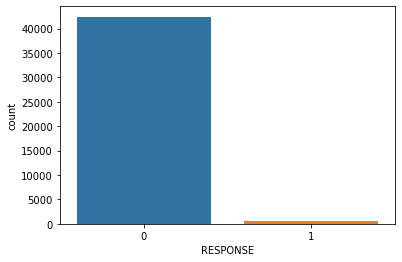

In [217]:
sns.countplot(data=mailout_train, x='RESPONSE')

Probably will use AUC to start, that's a good metric for classification

In [218]:
X_train.shape[0]

30073

In [219]:
X_train_clean = a.transform(X_train)

Replacing unknowns...


/home/patrick/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Fixing columns 18 and 19...
Remove extraneous columns
One Hot Encode...
Scaling...
Imputing...


/home/patrick/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [220]:
lr = LogisticRegression(max_iter=1000, random_state=seed)

In [221]:
lr.fit(X_train_clean.values, y_train.values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=60611, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [222]:
X_test_clean = a.transform(X_test)

Replacing unknowns...
Fixing columns 18 and 19...
Remove extraneous columns
One Hot Encode...
Scaling...
Imputing...


In [223]:
baseline_lr_train = roc_auc_score(y_train, lr.predict_proba(X_train_clean)[:, 1])
baseline_lr_test = roc_auc_score(y_test, lr.predict_proba(X_test_clean)[:, 1])
print('Baseline logistic regression evaluation:')
print(f'\tTraining dataset: {baseline_lr_train}')
print(f'\tTest dataset: {baseline_lr_test}')

Baseline logistic regression evaluation:
	Training dataset: 0.7662547023325308
	Test dataset: 0.5759433466009714


In [225]:
import xgboost as xgb

In [226]:
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', random_state=seed)

In [229]:
xgb_classifier.fit(X_train_clean, y_train.values.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic',
              random_state=60611, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [233]:
roc_auc_score(y_test, xgb_classifier.predict_proba(X_test_clean)[:,1])

0.5320417842927531